In [1]:
import theano
from theano import tensor as T
import lasagne
from lasagne.layers import *
from lasagne.init import *
from lasagne.nonlinearities import *
from lasagne.objectives import *
from lasagne.updates import *
import sys
sys.path.append("../../modules/")
import helper as hp
import matplotlib.pyplot as plt
%matplotlib inline
import draw_net
from IPython.display import Image
import numpy as np
reload(draw_net)
from skimage import io
import cPickle as pickle
import os
from time import time

//anaconda/lib/python2.7/site-packages/Theano-0.8.0.dev0-py2.7.egg/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [4]:
?draw_net.get_pydot_graph

In [2]:
os.environ["DATA_DIR"] = "/Volumes/CB_RESEARCH/dr-data/train-trim-ben-r400-512/"

In [3]:
with open("dr.pkl") as f:
    dat = pickle.load(f)
X_left, X_right, y = dat
X_left = np.asarray(X_left)
X_right = np.asarray(X_right)
y = np.asarray(y, dtype="int32")

In [4]:
np.random.seed(0)

In [5]:
idxs = [x for x in range(0, len(X_left))]
np.random.shuffle(idxs)

In [6]:
X_train_left = X_left[idxs][0 : int(0.9*X_left.shape[0])]
X_train_right = X_right[idxs][0 : int(0.9*X_right.shape[0])]
y_train = y[idxs][0 : int(0.9*y.shape[0])]

X_valid_left = X_left[idxs][int(0.9*X_left.shape[0]) ::]
X_valid_right = X_right[idxs][int(0.9*X_right.shape[0]) ::]
y_valid = y[idxs][int(0.9*y.shape[0]) ::]

-----

In [6]:
def get_net(net_fn, args={}):
    # ----
    X_left = T.tensor4('X_left')
    X_right = T.tensor4('X_right')
    y = T.ivector('y')
    # ----
    
    cfg = net_fn(args)
    l_out = cfg["l_out"]
    l_in_left = cfg["l_in_left"]
    l_in_right = cfg["l_in_right"]
    
    net_out = get_output(l_out, {l_in_left: X_left, l_in_right: X_right})
    net_out_det = get_output(l_out, {l_in_left: X_left, l_in_right: X_right}, deterministic=True)
    
    if not args["kappa_loss"]:
        loss = categorical_crossentropy(net_out, y).mean()
        loss_det = categorical_crossentropy(net_out_det, y).mean()
    else:
        loss = get_kappa_loss(5)(net_out, y).mean()
        loss_det = get_kappa_loss(5)(net_out_det, y).mean()
    
    if "l2" in args:
        sys.stderr.write("adding l2: %f\n" % args["l2"])
        loss += args["l2"]*regularize_layer_params(l_out, l2)
        loss_det += args["l2"]*regularize_layer_params(l_out, l2)
    params = get_all_params(l_out, trainable=True)
    if "max_norm" in args:
        grads = total_norm_constraint( T.grad(loss, params), max_norm=args["max_norm"])
    else:
        grads = T.grad(loss, params)
    learning_rate = theano.shared(floatX(0.01)) if "learning_rate" not in args else theano.shared(floatX(args["learning_rate"]))
    momentum = 0.9 if "momentum" not in args else args["momentum"]
    if "rmsprop" in args:
        sys.stderr.write("using rmsprop instead of nesterov momentum...\n")
        updates = rmsprop(grads, params, learning_rate=learning_rate)
    else:
        updates = nesterov_momentum(grads, params, learning_rate=learning_rate, momentum=momentum)
    # index fns
    bs = args["batch_size"]
    train_fn = theano.function(inputs=[X_left,X_right,y], outputs=loss, updates=updates)
    loss_fn = theano.function(inputs=[X_left,X_right,y], outputs=loss_det)
    preds_fn = theano.function(inputs=[X_left,X_right], outputs=T.argmax(net_out_det,axis=1))
    
    return {
        "train_fn": train_fn,
        "loss_fn": loss_fn,
        "preds_fn": preds_fn,
        "l_out": l_out,
        "learning_rate": learning_rate,
        "bs": bs
    }


In [35]:

def net(args={}):
    
    #conv_p, fc_p = args["fc_p"]
    
    l_in_left = InputLayer( (None, 3, 512, 512) )
    l_in_right = InputLayer( (None, 3, 512, 512) )
    # left image
    l_topleft_left = SliceLayer( SliceLayer(l_in_left, indices=slice(0,256), axis=2), indices=slice(0,256), axis=3 )
    l_bottomleft_left = SliceLayer( SliceLayer(l_in_left, indices=slice(256,512), axis=2), indices=slice(0,256), axis=3 )
    l_topright_left = SliceLayer( SliceLayer(l_in_left, indices=slice(0,256), axis=2), indices=slice(256,512), axis=3 )
    l_bottomright_left = SliceLayer( SliceLayer(l_in_left, indices=slice(256,512), axis=2), indices=slice(256,512), axis=3 )
    # right image
    l_topleft_right = SliceLayer( SliceLayer(l_in_right, indices=slice(0,256), axis=2), indices=slice(0,256), axis=3 )
    l_bottomleft_right = SliceLayer( SliceLayer(l_in_right, indices=slice(256,512), axis=2), indices=slice(0,256), axis=3 )
    l_topright_right = SliceLayer( SliceLayer(l_in_right, indices=slice(0,256), axis=2), indices=slice(256,512), axis=3 )
    l_bottomright_right = SliceLayer( SliceLayer(l_in_right, indices=slice(256,512), axis=2), indices=slice(256,512), axis=3 ) 
    
    sys.stderr.write("fc_p = %f\n" % args["fc_p"])
    
    def net_block(quadrant, dd):
        #l_in = InputLayer(
        #    shape=(None, 3, 256, 256),
        #)
        # { "type": "CONV", "num_filters": 32, "filter_size": 3, "pool_size": 3, "pool_stride": 2, "nonlinearity": "LReLU" },
        l_conv1 = Conv2DLayer(
            quadrant,
            num_filters=32,
            filter_size=(3,3),
            nonlinearity=leaky_rectify,
            W=GlorotUniform(gain="relu") if "l_conv1" not in dd else dd["l_conv1"].W,
            b=Constant(0.) if "l_conv1" not in dd else dd["l_conv1"].b
        )
        l_pool1 = MaxPool2DLayer(
            l_conv1,
            pool_size=(3,3),
            stride=2
        )
        # { "type": "CONV", "dropout": 0.1, "num_filters": 64, "filter_size": 3, "pool_size": 3, "pool_stride": 2, "nonlinearity": "LReLU" }
        #l_dropout1 = DropoutLayer(l_pool1, p=0.1)
        l_conv2 = Conv2DLayer(
            l_pool1,
            num_filters=64,
            filter_size=(3,3),
            nonlinearity=leaky_rectify,
            W=GlorotUniform(gain="relu") if "l_conv2" not in dd else dd["l_conv2"].W,
            b=Constant(0.) if "l_conv2" not in dd else dd["l_conv2"].b
        )
        l_pool2 = MaxPool2DLayer(
            l_conv2,
            pool_size=(3,3),
            stride=2
        )
        # { "type": "CONV", "dropout": 0.1, "num_filters": 128, "filter_size": 3, "nonlinearity": "LReLU" },
        #l_dropout2 = DropoutLayer(l_pool2, p=0.1)
        l_conv3 = Conv2DLayer(
            l_pool2,
            num_filters=128,
            filter_size=(3,3),
            nonlinearity=leaky_rectify,
            W=GlorotUniform(gain="relu") if "l_conv3" not in dd else dd["l_conv3"].W,
            b=Constant(0.) if "l_conv3" not in dd else dd["l_conv3"].b
        )
        # { "type": "CONV", "dropout": 0.1, "num_filters": 128, "filter_size": 3, "pool_size": 3, "pool_stride": 2, "nonlinearity": "LReLU" },
        #l_dropout3 = DropoutLayer(l_conv3, p=0.1)
        l_conv4 = Conv2DLayer(
            l_conv3,
            num_filters=128,
            filter_size=(3,3),
            nonlinearity=leaky_rectify,
            W=GlorotUniform(gain="relu") if "l_conv4" not in dd else dd["l_conv4"].W,
            b=Constant(0.) if "l_conv4" not in dd else dd["l_conv4"].b
        )
        l_pool3 = MaxPool2DLayer(
            l_conv4,
            pool_size=(3,3),
            stride=2
        )
        # { "type": "CONV", "dropout": 0.1, "num_filters": 128, "filter_size": 3, "pool_size": 3, "pool_stride": 2, "nonlinearity": "LReLU" },
        #l_dropout4 = DropoutLayer(l_pool3, p=0.1)
        l_conv5 = Conv2DLayer(
            l_pool3,
            num_filters=256,
            filter_size=(3,3),
            nonlinearity=leaky_rectify,
            W=GlorotUniform(gain="relu") if "l_conv5" not in dd else dd["l_conv5"].W,
            b=Constant(0.) if "l_conv5" not in dd else dd["l_conv5"].b
        )
        #l_dropout5 = DropoutLayer(l_conv5, p=0.1)
        l_conv6 = Conv2DLayer(
            l_conv5,
            num_filters=256,
            filter_size=(3,3),
            nonlinearity=leaky_rectify,
            W=GlorotUniform(gain="relu") if "l_conv6" not in dd else dd["l_conv6"].W,
            b=Constant(0.) if "l_conv6" not in dd else dd["l_conv6"].b
        )
        # maxpool size 3 stride 2
        l_pool4 = MaxPool2DLayer(
            l_conv6,
            pool_size=(3,3),
            stride=2
        )
        # { "type": "CONV", "dropout": 0.1, "num_filters": 256, "filter_size": 3, "pool_size": 2, "pool_stride": 2, "nonlinearity": "LReLU" },
        #l_dropout5 = DropoutLayer(l_pool4, p=0.1)
        l_conv7 = Conv2DLayer(
            l_pool4,
            num_filters=512,
            filter_size=(3,3),
            nonlinearity=leaky_rectify,
            W=GlorotUniform(gain="relu") if "l_conv7" not in dd else dd["l_conv7"].W,
            b=Constant(0.) if "l_conv7" not in dd else dd["l_conv7"].b
        )
        #l_dropout6 = DropoutLayer(l_conv6, p=0.1)
        l_conv8 = Conv2DLayer(
            l_conv7,
            num_filters=512,
            filter_size=(3,3),
            nonlinearity=leaky_rectify,
            W=GlorotUniform(gain="relu") if "l_conv8" not in dd else dd["l_conv8"].W,
            b=Constant(0.) if "l_conv8" not in dd else dd["l_conv8"].b
        )
        
        l_pool5 = MaxPool2DLayer(
            l_conv8,
            pool_size=(2,2),
            stride=2
        )

        # { "type": "FC", "dropout": 0.5, "num_units": 2048, "pool_size": 2, "nonlinearity": "LReLU" },
        #l_dropout7 = lasagne.layers.DropoutLayer(l_conv7, p=0.5)
        l_hidden1 = lasagne.layers.DenseLayer(
            l_pool5,
            num_units=512,
            nonlinearity=leaky_rectify,
            W=GlorotUniform(gain="relu") if "l_hidden1" not in dd else dd["l_hidden1"].W,
            b=Constant(0.) if "l_hidden1" not in dd else dd["l_hidden1"].b
        )

        #l_pool6 = lasagne.layers.FeaturePoolLayer(
        #    l_hidden1,
        #    pool_size=2
        #)
        
        # { "type": "FC", "dropout": 0.5, "num_units": 2048, "pool_size": 2, "nonlinearity": "LReLU" },
        l_dropout8 = lasagne.layers.DropoutLayer(l_hidden1, p=args["fc_p"])
        l_hidden2 = lasagne.layers.DenseLayer(
            l_dropout8,
            num_units=512,
            nonlinearity=leaky_rectify,
            W=GlorotUniform(gain="relu") if "l_hidden2" not in dd else dd["l_hidden2"].W,
            b=Constant(0.) if "l_hidden2" not in dd else dd["l_hidden2"].b
        )
        
        #l_pool7 = lasagne.layers.FeaturePoolLayer(
        #    l_hidden2,
        #    pool_size=2
        #)
        
        # { "type": "OUTPUT", "dropout": 0.5, "nonlinearity": "sigmoid" }
        #l_dropout8 = lasagne.layers.DropoutLayer(l_pool7, p=0.5)
        #l_out = lasagne.layers.DenseLayer(
        #    l_dropout8,
        #    num_units=5,
        #    nonlinearity=softmax,
        #    W=GlorotUniform()
        #)
        #return l_out

        #l_out = l_pool7
        #l_out = l_hidden2

        return {
            "l_conv1": l_conv1,
            "l_conv2": l_conv2,
            "l_conv3": l_conv3,
            "l_conv4": l_conv4,
            "l_conv5": l_conv5,
            "l_conv6": l_conv6,
            "l_conv7": l_conv7,
            "l_conv8": l_conv8,
            "l_hidden1": l_hidden1,
            "l_hidden2": l_hidden2,
            "l_out": l_hidden2
        }

    topleft_conv_left = net_block(l_topleft_left, {})
    bottomleft_conv_left = net_block(l_bottomleft_left, topleft_conv_left)
    topright_conv_left = net_block(l_topright_left, topleft_conv_left)
    bottomright_conv_left = net_block(l_bottomright_left, topleft_conv_left)

    topleft_conv_right = net_block(l_topleft_right, topleft_conv_left)
    bottomleft_conv_right = net_block(l_bottomleft_right, topleft_conv_left)
    topright_conv_right = net_block(l_topright_right, topleft_conv_left)
    bottomright_conv_right = net_block(l_bottomright_right, topleft_conv_left)

    for layer in get_all_layers(topleft_conv_left["l_out"]):
        sys.stderr.write( str(layer) + " " + str(layer.output_shape) + "\n")
    
    l_concat_left = ConcatLayer([
        topleft_conv_left["l_out"], 
        bottomleft_conv_left["l_out"], 
        topright_conv_left["l_out"], 
        bottomright_conv_left["l_out"],   
    ])

    l_concat_right = ConcatLayer([
        topleft_conv_right["l_out"], 
        bottomleft_conv_right["l_out"], 
        topright_conv_right["l_out"], 
        bottomright_conv_right["l_out"],   
    ])

    l_merge = ElemwiseSumLayer(
        [l_concat_left, l_concat_right]
    )
    
    l_dropout = DropoutLayer(l_merge, p=args["fc_p"])

    l_out = lasagne.layers.DenseLayer(
        l_dropout,
        num_units=5,
        nonlinearity=softmax,
        W=GlorotUniform()
    )

    sys.stderr.write("number of params: %i\n" % count_params(l_out))
    
    return {"l_out": l_out, "l_in_left": l_in_left, "l_in_right": l_in_right}


In [3]:
def iterate(X_arr_left, X_arr_right, y_arr, bs, augment):
    assert X_arr_left.shape[0] == X_arr_right.shape[0] == y_arr.shape[0]
    b = 0
    DATA_DIR = os.environ["DATA_DIR"]
    while True:
        if b*bs >= X_arr_left.shape[0]:
            break
        this_X_left, this_X_right, this_y = \
            X_arr_left[b*bs:(b+1)*bs], X_arr_right[b*bs:(b+1)*bs], y_arr[b*bs:(b+1)*bs]
        # load the images
        images_for_this_X_left = \
            [ hp.load_image("%s/%s.jpeg" % (DATA_DIR,filename), augment=augment) for filename in this_X_left ]
        images_for_this_X_left = np.asarray(images_for_this_X_left, dtype="float32")
        
        images_for_this_X_right = \
            [ hp.load_image("%s/%s.jpeg" % (DATA_DIR,filename), augment=augment) for filename in this_X_right ]
        images_for_this_X_right = np.asarray(images_for_this_X_right, dtype="float32")
        
        print images_for_this_X_left.shape
        print images_for_this_X_right.shape
        print this_y.shape

        yield images_for_this_X_left, images_for_this_X_right, this_y
        
        # ---
        b += 1


In [4]:
def train(net_cfg, 
          num_epochs,
          data,
          out_file=None,
          print_out=True,
          debug=False,
          resume=None,
          schedule={}):
    # prepare the out_file
    l_out = net_cfg["l_out"]
    f = None
    if resume == None:
        if out_file != None:
            f = open("%s.txt" % out_file, "wb")
            f.write("epoch,train_loss,avg_valid_loss,valid_accuracy,time\n")
        if print_out:
            print "epoch,train_loss,avg_valid_loss,valid_accuracy,time"
    else:
        sys.stderr.write("resuming training...\n")
        if out_file != None:
            f = open("%s.txt" % out_file, "ab")
        with open(resume) as g:
            set_all_param_values(l_out, pickle.load(g))          
    
    # extract functions
    X_train_left, X_train_right, y_train, X_valid_left, X_valid_right, y_valid = data
    train_fn, loss_fn, preds_fn = net_cfg["train_fn"], net_cfg["loss_fn"], net_cfg["preds_fn"]
    learning_rate = net_cfg["learning_rate"]
    bs = net_cfg["bs"]
    
    # training
    train_idxs = [x for x in range(0, X_train_left.shape[0])]
    
    if debug:
        sys.stderr.write("idxs: %s\n" % train_idxs)
    for epoch in range(0, num_epochs):
        
        if epoch+1 in schedule:
            sys.stderr.write("changing learning rate to: %f" % schedule[epoch+1])
            learning_rate.set_value( floatX(schedule[epoch+1]) )
        
        np.random.shuffle(train_idxs)
        X_train_left, X_train_right = X_train_left[train_idxs], X_train_right[train_idxs]
        y_train = y_train[train_idxs]
        
        # training loop
        this_train_losses = []
        t0 = time()
        for X_train_batch_left, X_train_batch_right, y_train_batch in iterate(X_train_left, X_train_right, y_train, bs, True):
            this_train_losses.append( train_fn(X_train_batch_left, X_train_batch_right, y_train_batch) )
        time_taken = time() - t0
        
        # validation loss loop
        this_valid_losses = []
        for X_valid_batch_left, X_valid_batch_right, y_valid_batch in iterate(X_valid_left, X_valid_right, y_valid, bs, False):
            this_valid_losses.append( loss_fn(X_valid_batch_left, X_valid_batch_right, y_valid_batch) )
        avg_valid_loss = np.mean(this_valid_losses)
        
        # validation accuracy loop
        this_valid_preds = []
        for X_valid_batch_left, X_valid_batch_right, _ in iterate(X_valid_left, X_valid_right, y_valid, bs, False):
            this_valid_preds += preds_fn(X_valid_batch_left, X_valid_batch_right).tolist()
        valid_acc = np.mean( this_valid_preds == y_valid )
        
        # validation set kappa
        valid_kappa = hp.weighted_kappa(human_rater=this_valid_preds, actual_rater=y_valid, num_classes=5)
        
        ## ------------ ##
        if f != None:
            f.write(
                "%i,%f,%f,%f,%f,%f\n" %
                    (epoch+1, np.mean(this_train_losses), avg_valid_loss, valid_acc, valid_kappa, time_taken) 
            )
            f.flush()
        if print_out:
            print "%i,%f,%f,%f,%f,%f" % \
                (epoch+1, np.mean(this_train_losses), avg_valid_loss, valid_acc, valid_kappa, time_taken)
            
        with open("models/%s.model.%i" % (os.path.basename(out_file),epoch+1), "wb") as g:
            pickle.dump(get_all_param_values(l_out), g, pickle.HIGHEST_PROTOCOL) 
            
    if f != None:
        f.close()

fc_p = 0.500000
<lasagne.layers.input.InputLayer object at 0x11999df50> (None, 3, 512, 512)
<lasagne.layers.shape.SliceLayer object at 0x11999d0d0> (None, 3, 256, 512)
<lasagne.layers.shape.SliceLayer object at 0x11999d110> (None, 3, 256, 256)
<lasagne.layers.conv.Conv2DLayer object at 0x11999d1d0> (None, 32, 254, 254)
<lasagne.layers.pool.MaxPool2DLayer object at 0x11999d490> (None, 32, 126, 126)
<lasagne.layers.conv.Conv2DLayer object at 0x11999d590> (None, 64, 124, 124)
<lasagne.layers.pool.MaxPool2DLayer object at 0x10e5d3a10> (None, 64, 61, 61)
<lasagne.layers.conv.Conv2DLayer object at 0x119991410> (None, 128, 59, 59)
<lasagne.layers.conv.Conv2DLayer object at 0x10e2946d0> (None, 128, 57, 57)
<lasagne.layers.pool.MaxPool2DLayer object at 0x11999d450> (None, 128, 28, 28)
<lasagne.layers.conv.Conv2DLayer object at 0x1199916d0> (None, 256, 26, 26)
<lasagne.layers.conv.Conv2DLayer object at 0x119991390> (None, 256, 24, 24)
<lasagne.layers.pool.MaxPool2DLayer object at 0x11999d9d0> (N

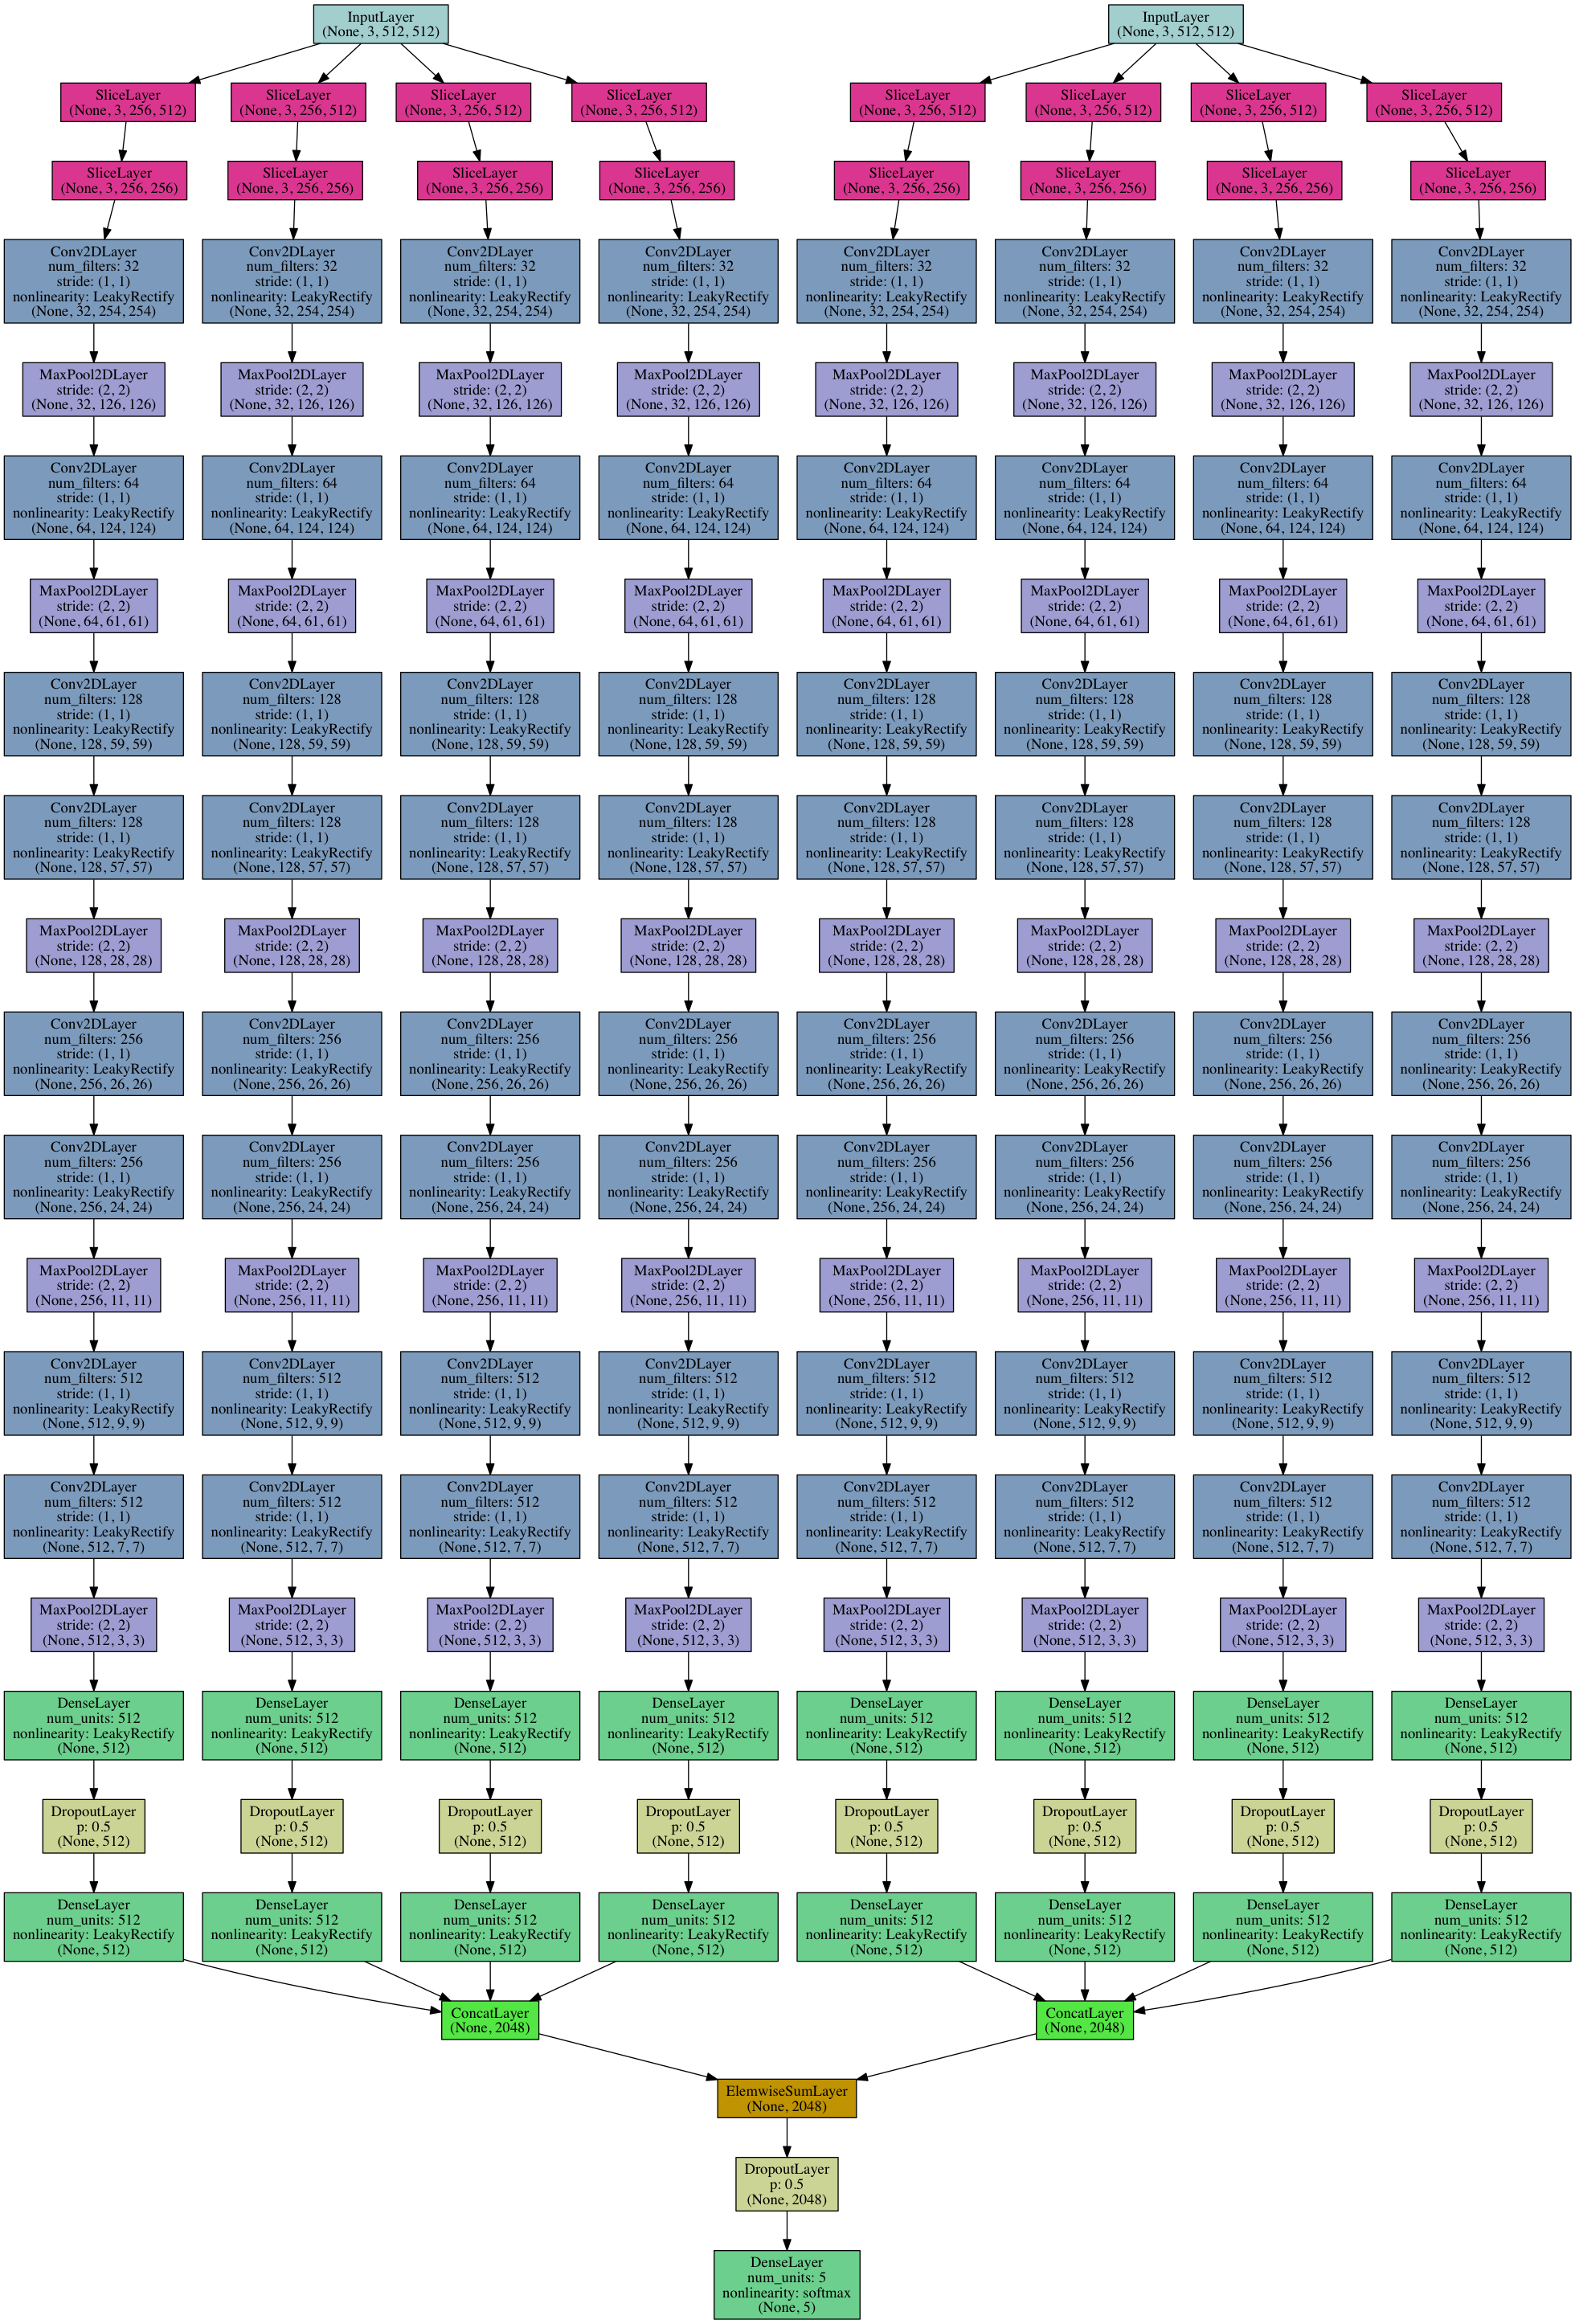

In [34]:
draw_net.draw_to_notebook(get_all_layers(net({"fc_p":0.5})["l_out"]), verbose=True)

-----

In [142]:
def residual_block(layer, n_out_channels, prefix, stride=1, dd={}):
    conv = layer
    nonlinearity = rectify
    if stride > 1:
        layer = Pool2DLayer(layer, pool_size=1, stride=stride, mode="average_inc_pad")
    if (n_out_channels != layer.output_shape[1]):
        diff = n_out_channels-layer.output_shape[1]
        if diff % 2 == 0: 
            width_tp = ((diff/2, diff/2),)
        else:
            width_tp = (((diff/2)+1, diff/2),)
        layer = pad(layer, batch_ndim=1, width=width_tp)
    conv = Conv2DLayer(conv, 
                       num_filters=n_out_channels,
                       filter_size=(3,3), 
                       stride=(stride,stride), 
                       pad=(1,1), 
                       nonlinearity=linear, 
                       W=HeNormal(gain="relu") if prefix+"_1" not in dd else dd[prefix+"_1"].W,
                       b=Constant(0.) if prefix+"_1" not in dd else dd[prefix+"_1"].b)
    if prefix+"_1" not in dd:
        dd[prefix+"_1"] = conv
        print prefix+"_1"
    conv = BatchNormLayer(conv)
    conv = NonlinearityLayer(conv, nonlinearity=nonlinearity)
    conv = Conv2DLayer(conv, 
                       num_filters=n_out_channels,
                       filter_size=(3,3), 
                       stride=(1,1), 
                       pad=(1,1), 
                       nonlinearity=linear, 
                       W=HeNormal(gain="relu") if prefix+"_2" not in dd else dd[prefix+"_2"].W,
                       b=Constant(0.) if prefix+"_2" not in dd else dd[prefix+"_2"].b)
    if prefix+"_2" not in dd:
        dd[prefix+"_2"] = conv
        print prefix+"_2"
    conv = BatchNormLayer(conv)
    return NonlinearityLayer(ElemwiseSumLayer([conv, layer]), nonlinearity=nonlinearity)

In [143]:
def resnet(quadrant, dd):
    # 34-layer resnet as per:
    # https://arxiv.org/pdf/1512.03385v1.pdf
    layer = Conv2DLayer(quadrant, 
                        num_filters=64, 
                        filter_size=7, 
                        stride=2, 
                        nonlinearity=rectify, 
                        pad='same', 
                        W=HeNormal(gain="relu") if "conv1" not in dd else dd["conv1"].W,
                        b=Constant(0.) if "conv1" not in dd else dd["conv1"].b)
    if "conv1" not in dd:
        dd["conv1"] = layer
        print "conv1"
    layer = MaxPool2DLayer(layer, pool_size=3, stride=2)
    for i in range(2):
        layer = residual_block(layer, 64, prefix="a%i" % i, dd=dd)
    layer = residual_block(layer, 128, prefix="aa%i" % i, stride=2, dd=dd)
    for i in range(2):
        layer = residual_block(layer, 128, prefix="b%i" % i, dd=dd)
    layer = residual_block(layer, 256, prefix="bb%i" % i, stride=2, dd=dd)
    for i in range(2):
        layer = residual_block(layer, 256, prefix="c%i" % i, dd=dd)
    layer = residual_block(layer, 512, prefix="cc%i" % i, stride=2, dd=dd)
    for i in range(2):
        layer = residual_block(layer, 512, prefix="dd%i" % i, dd=dd)
    layer = Pool2DLayer(layer, pool_size=8, stride=1, mode="average_inc_pad")
    #layer = DenseLayer(layer, 
    #                   num_units=5, 
    #                   nonlinearity=softmax, 
    #                   W=HeNormal() if "softmax" not in dd else dd["softmax"])
    layer = FlattenLayer(layer)
    dd["l_out"] = layer
    return dd

In [144]:
resnet(l_in, {})

conv1
a0_1
a0_2
a1_1
a1_2
aa1_1
aa1_2
b0_1
b0_2
b1_1
b1_2
bb1_1
bb1_2
c0_1
c0_2
c1_1
c1_2
cc1_1
cc1_2
dd0_1
dd0_2
dd1_1
dd1_2


{'a0_1': <lasagne.layers.conv.Conv2DLayer at 0x10a1b5090>,
 'a0_2': <lasagne.layers.conv.Conv2DLayer at 0x10a2b26d0>,
 'a1_1': <lasagne.layers.conv.Conv2DLayer at 0x10a1cfe90>,
 'a1_2': <lasagne.layers.conv.Conv2DLayer at 0x10a16c410>,
 'aa1_1': <lasagne.layers.conv.Conv2DLayer at 0x10a171690>,
 'aa1_2': <lasagne.layers.conv.Conv2DLayer at 0x10a193e10>,
 'b0_1': <lasagne.layers.conv.Conv2DLayer at 0x10a17af10>,
 'b0_2': <lasagne.layers.conv.Conv2DLayer at 0x10a11dfd0>,
 'b1_1': <lasagne.layers.conv.Conv2DLayer at 0x10b3a4050>,
 'b1_2': <lasagne.layers.conv.Conv2DLayer at 0x10b388810>,
 'bb1_1': <lasagne.layers.conv.Conv2DLayer at 0x10b37ca90>,
 'bb1_2': <lasagne.layers.conv.Conv2DLayer at 0x10a150050>,
 'c0_1': <lasagne.layers.conv.Conv2DLayer at 0x10a146490>,
 'c0_2': <lasagne.layers.conv.Conv2DLayer at 0x10a160d50>,
 'c1_1': <lasagne.layers.conv.Conv2DLayer at 0x10a16b650>,
 'c1_2': <lasagne.layers.conv.Conv2DLayer at 0x10e0d1a10>,
 'cc1_1': <lasagne.layers.conv.Conv2DLayer at 0x10a1

In [152]:

def resnet_net(args={}):
    
    #conv_p, fc_p = args["fc_p"]
    
    l_in_left = InputLayer( (None, 3, 512, 512) )
    l_in_right = InputLayer( (None, 3, 512, 512) )
    # left image
    l_topleft_left = SliceLayer( SliceLayer(l_in_left, indices=slice(0,256), axis=2), indices=slice(0,256), axis=3 )
    l_bottomleft_left = SliceLayer( SliceLayer(l_in_left, indices=slice(256,512), axis=2), indices=slice(0,256), axis=3 )
    l_topright_left = SliceLayer( SliceLayer(l_in_left, indices=slice(0,256), axis=2), indices=slice(256,512), axis=3 )
    l_bottomright_left = SliceLayer( SliceLayer(l_in_left, indices=slice(256,512), axis=2), indices=slice(256,512), axis=3 )
    # right image
    l_topleft_right = SliceLayer( SliceLayer(l_in_right, indices=slice(0,256), axis=2), indices=slice(0,256), axis=3 )
    l_bottomleft_right = SliceLayer( SliceLayer(l_in_right, indices=slice(256,512), axis=2), indices=slice(0,256), axis=3 )
    l_topright_right = SliceLayer( SliceLayer(l_in_right, indices=slice(0,256), axis=2), indices=slice(256,512), axis=3 )
    l_bottomright_right = SliceLayer( SliceLayer(l_in_right, indices=slice(256,512), axis=2), indices=slice(256,512), axis=3 ) 

    topleft_conv_left = resnet(l_topleft_left, {})
    bottomleft_conv_left = resnet(l_bottomleft_left, topleft_conv_left)
    topright_conv_left = resnet(l_topright_left, topleft_conv_left)
    bottomright_conv_left = resnet(l_bottomright_left, topleft_conv_left)

    topleft_conv_right = resnet(l_topleft_right, topleft_conv_left)
    bottomleft_conv_right = resnet(l_bottomleft_right, topleft_conv_left)
    topright_conv_right = resnet(l_topright_right, topleft_conv_left)
    bottomright_conv_right = resnet(l_bottomright_right, topleft_conv_left)

    for layer in get_all_layers(topleft_conv_left["l_out"]):
        sys.stderr.write( str(layer) + " " + str(layer.output_shape) + "\n")
    
    l_concat_left = ConcatLayer([
        topleft_conv_left["l_out"], 
        bottomleft_conv_left["l_out"], 
        topright_conv_left["l_out"], 
        bottomright_conv_left["l_out"],   
    ])

    l_concat_right = ConcatLayer([
        topleft_conv_right["l_out"], 
        bottomleft_conv_right["l_out"], 
        topright_conv_right["l_out"], 
        bottomright_conv_right["l_out"],   
    ])

    l_merge = ElemwiseSumLayer(
        [l_concat_left, l_concat_right]
    )
    
    l_dropout = DropoutLayer(l_merge, p=args["fc_p"])

    l_out = lasagne.layers.DenseLayer(
        l_dropout,
        num_units=5,
        nonlinearity=softmax,
        W=HeNormal()
    )

    sys.stderr.write("number of params: %i\n" % count_params(l_out))
    
    return {"l_out": l_out, "l_in_left": l_in_left, "l_in_right": l_in_right}


In [150]:
out = resnet_net({"fc_p": 0.5})

conv1
a0_1
a0_2
a1_1
a1_2
aa1_1
aa1_2
b0_1
b0_2
b1_1
b1_2
bb1_1
bb1_2
c0_1
c0_2
c1_1
c1_2
cc1_1
cc1_2
dd0_1
dd0_2
dd1_1
dd1_2
conv1
a0_1
a0_2
a1_1
a1_2
aa1_1
aa1_2
b0_1
b0_2
b1_1
b1_2
bb1_1
bb1_2
c0_1
c0_2
c1_1
c1_2
cc1_1
cc1_2
dd0_1
dd0_2
dd1_1
dd1_2

<lasagne.layers.input.InputLayer object at 0x10e9789d0> (None, 3, 512, 512)
<lasagne.layers.shape.SliceLayer object at 0x10b397310> (None, 3, 256, 512)
<lasagne.layers.shape.SliceLayer object at 0x10b397390> (None, 3, 256, 256)
<lasagne.layers.conv.Conv2DLayer object at 0x10a2bce10> (None, 64, 128, 128)
<lasagne.layers.pool.MaxPool2DLayer object at 0x10a2bcd50> (None, 64, 63, 63)
<lasagne.layers.conv.Conv2DLayer object at 0x10a2bcd90> (None, 64, 63, 63)
<lasagne.layers.normalization.BatchNormLayer object at 0x10a168450> (None, 64, 63, 63)
<lasagne.layers.special.NonlinearityLayer object at 0x10a1b5b10> (None, 64, 63, 63)
<lasagne.layers.conv.Conv2DLayer object at 0x10df141d0> (None, 64, 63, 63)
<lasagne.layers.normalization.BatchNormLayer object at 0x10df14210> (None, 64, 63, 63)
<lasagne.layers.merge.ElemwiseSumLayer object at 0x10df14950> (None, 64, 63, 63)
<lasagne.layers.special.NonlinearityLayer object at 0x10a11d790> (None, 64, 63, 63)
<lasagne.layers.conv.Conv2DLayer object at 0

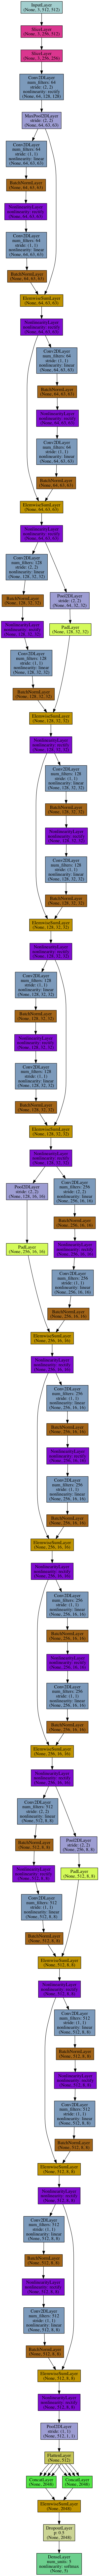

In [147]:
draw_net.draw_to_notebook(get_all_layers(out["l_out"]), verbose=True)

In [151]:
get_all_params(out["l_out"], trainable=True)

[W,
 b,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 ga